In [4]:
import time
import os
import numpy as np
import torch
import torchvision.transforms as tv
from torchvision.utils import make_grid
from PIL import Image
from torchvision.transforms import Compose
import logging
import matplotlib.pyplot as plt
import pandas as pd
import glob
%matplotlib inline

In [5]:
'''Inference workflow 
 model = load_model(model_path) ->
 show_img_with_pred(image_path, model, show_results=1) | batch_prediction(images_folder_path, model, save_path='results.csv') '''

"Inference workflow \n model = load_model(model_path) ->\n show_img_with_pred(image_path, model, show_results=1) | batch_prediction(images_folder_path, model, save_path='results.csv') "

In [6]:
mylogs = logging.getLogger()
mylogs.setLevel(logging.INFO)
# Logging to file
file = logging.FileHandler("inference.log", mode='w')
file.setLevel(logging.INFO)
fileformat = logging.Formatter("%(asctime)s:%(levelname)s:%(message)s",datefmt="%H:%M:%S")
file.setFormatter(fileformat)
mylogs.addHandler(file)
# Logging to console
stream = logging.StreamHandler()
stream.setLevel(logging.INFO)
mylogs.addHandler(stream)
mylogs.info("Inference")

Inference


In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
mylogs.info(f"Device is: {str(device)}")

Device is: cuda


In [8]:
def load_model(model_path):
    ''' Loads a model and its state dict. Accepts path to the model, returns the model. Default cnn type is resnet18 '''
    saved_model = torch.load(f'{model_path}')
    model_name  = saved_model['model_name']
    categories = saved_model['сategories']
    mylogs.info("Model: " + model_name)

    import resnet
    if model_name == 'ResNet18':
            model = resnet.ResNet18()
    elif model_name == 'ResNet34':
            model = resnet.ResNet34()
    elif model_name == 'ResNet50':
            model = resnet.ResNet50()
    elif model_name == 'ResNet101':
            model = resnet.ResNet101()
    elif model_name == 'ResNet152':
            model = resnet.ResNet152()
    else:
            model = resnet.ResNet18()    
    model.load_state_dict(torch.load(model_path)['model_state_dict'])
    model.eval()
    return model, categories

In [9]:
def transform():
    return tv.Compose([
        tv.ToTensor(),
        tv.Normalize((0, 0, 0),(1, 1, 1))
    ])

In [10]:
def image_loader(image_path):
    '''loads image,transforms it and returns  tensor'''
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img = transform()(img)
    #As torch models expects a batch, this image should be turned into a batch with 1 image 
    img  = img.unsqueeze(0)
    return img.cpu() 

In [11]:
def show_img_with_pred(image_path, model, show_results=1):
    ''' Predicts one image, returns prediction '''
    img = image_loader(image_path)
    img = img.to(device)
    model.to(device)
    with torch.no_grad():
        prediction = float(model(img))
    if show_results:
        img = img.to('cpu')
        model.to('cpu')
        figure, ax = plt.subplots(figsize=(6,6))
        plt.title(categories[0] if prediction <= 0.5 else categories[1], color= 'white')
        plt.imshow(make_grid(img,1).permute(1,2,0))
        ax.text(3, 8, (round(prediction,3)), style='italic',
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
        plt.show()
    return prediction

In [17]:
def batch_prediction(images_folder_path, model, save_path=None):
    ''' Make an inference on the images in the folder, returns a csv with results'''
    imgs_path_list = glob.glob(f'{images_folder_path}\*')
    mylogs.info(f"Inference started. \n {len(imgs_path_list)} images to predict")
    predictions = []
    names = []
    start_time = time.time()
    for image_path in imgs_path_list:
        names.append(os.path.split(image_path)[1])
        prediction = show_img_with_pred(image_path, model,show_results=0)
        predictions.append(prediction)
        
    df = pd.DataFrame({'Image' : pd.Series(names), 'Predictions' : pd.Series(predictions)})
    end_time = time.time()
    total_time = int(end_time - start_time)
    mylogs.info(f'Inference finished. Elapsed time: {total_time }s')
    if save_path:
        df.to_csv(save_path)
        mylogs.info(f'Results saved. Total time {round(total_time/60, 2)}')
    return df

In [21]:
model_path = "catsdogs_classification_ResNet18_inference.pt"
model, categories = load_model(model_path)

Model: ResNet18


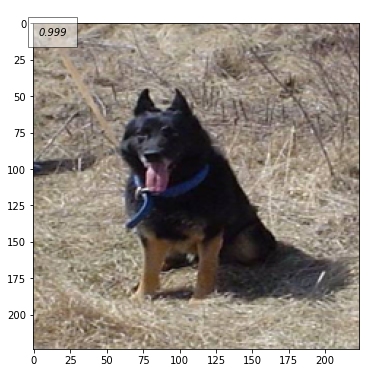

0.9988445043563843

In [22]:
image_path = r'E:\dogscats\test\12.jpg'
show_img_with_pred(image_path, model, show_results=1)

Inference started. 
 12500 images to predict
Inference finished. Elapsed time: 95s
Results saved. Total time 1.58


array([[<AxesSubplot:title={'center':'Predictions'}>]], dtype=object)

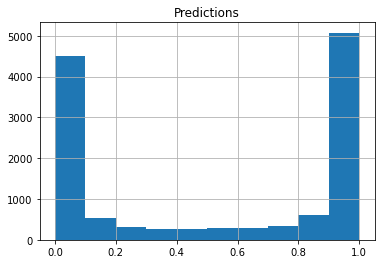

In [25]:
images_folder_path = r'E:/dogscats/test/'
df = batch_prediction(images_folder_path, model, save_path='Results.csv')
df.hist(column = "Predictions" )
